### Training the unet

In [7]:
# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda as cuda
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict

import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error
dtype = torch.FloatTensor
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Cuda active?
if cuda.is_available():
    dtype = torch.cuda.FloatTensor
    print("GPU: {}".format(cuda.get_device_name(0)))
    cuda_available = True
else:
    cuda_available = False
    print("Cuda unavailable.")

GPU: GeForce GTX 1080 Ti


In [8]:
#%%writefile hyperspectral_dataset.py
# Load data
import torch
from torch.utils.data import Dataset
import csv, numpy as np
import os
import OpenEXR as exr, Imath
from collections import defaultdict
from PIL import Image
from skimage.transform import resize
from torchvision import transforms as T

####################
# Helper functions #
####################




def readPNGImage(filedir, filename, channelrange, minwavelength, increment):
    """Helper function for reading patches from the set of png files from the CAVE dataset.
    """
    indexes = [int((wavelength-minwavelength)/increment + 1) for wavelength in channelrange]
    # Get image size:
    img = Image.open(os.path.join(filedir, "{}_{:02}.png".format(filename, 1)))
    full = np.zeros((len(channelrange),) + img.size, dtype=np.float16)
    img.close()
    for i, index in enumerate(indexes):
        img = Image.open(os.path.join(filedir, "{}_{:02}.png".format(filename, index)))
        # Divide by max val of np.uint16 to normalize image
        full[i,:,:] = np.array(img, dtype=np.float32)/np.iinfo(np.uint16).max
    return full

###########
# Dataset #
###########
# For reference, the csv field names: 
# fieldnames = ["type", "dir", "name", "row", "col", "side", "scale", "flip"]

class HyperspectralDataset(Dataset):
    def __init__(self, csvfile, minwavelength, maxwavelength, nchannels, height, width):
        """Open and load the lines of the csvfile."""
        self.minwavelength = minwavelength
        self.maxwavelength = maxwavelength
        self.channelrange = range(self.minwavelength, self.maxwavelength+1, 10)
        
        
        # Store dictionaries mapping the image name to
        # - a list of entries that stem from that image
        # - the datatype (exr or png) of the image
        # - the filepath to that image
        self.update_entries(csvfile)

    def update_entries(self, csvfile):
        """Refresh the dataset without reloading the images, but adding a different set of csv files."""
        self.dataEntries = []
        self.namesToImages = {}
        with open(csvfile, "r") as f:
            reader = csv.DictReader(f)
            for entry in reader:
                self.dataEntries.append(entry)
                # Add the full image to the dict if not already included.
                if entry["name"] not in self.namesToImages:
                    print("loading {}".format(entry["name"]))
                    # Need to read the image into the dictionary
                    if entry["type"] == "exr":
                        filepath = os.path.join(entry["dir"], entry["name"])
                        self.namesToImages[entry["name"]] = readEXRImage(filepath, self.channelrange)
                    elif entry["type"] == "png":
                        self.namesToImages[entry["name"]] = readPNGImage(entry["dir"], entry["name"],
                                                                           self.channelrange,
                                                                           self.minwavelength,
                                                                           10)
                    else:
                        raise ValueError("Invalid entry at row {} - Cannot load data of type '{}'.".format(idx, dtype))
                    print("\tSize: {} bytes.".format(self.namesToImages[entry["name"]].nbytes))
                    
    def __len__(self):
        return len(self.dataEntries)
    
    def __getitem__(self, idx):
        entry = self.dataEntries[idx]
        image = self.namesToImages[entry["name"]]
        side = int(entry["side"])
        scale = float(entry["scale"])
        i = int(entry["row"])
        j = int(entry["col"])
        shape = (int(side/scale),
                 int(side/scale)
                )
        patch = image[:, i:i+shape[0], j:j+shape[0]]
        # Resizing
        patch = resize(patch, (patch.shape[0], side, side), mode="constant")
        
        

        # Convert to Torch tensor and return
        out = torch.Tensor(patch.copy()).type(dtype).cpu()
        #print(torch.min(out))
        return out



In [9]:
# %%writefile unet.py
import torch
import torch.nn as nn
import torch.cuda as cuda
from collections import OrderedDict

import torch.nn as nn
import torch
from torch import autograd

#把常用的2个卷积操作简单封装下
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), #添加了BN层
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2,inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Unet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Unet, self).__init__()
        self.filter_spectral_response = nn.Conv2d(in_ch, 3, 1)
        self.conv1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        # 逆卷积，也可以使用上采样
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64, out_ch, 1)
        

    def forward(self, x):
        x = self.filter_spectral_response(x)
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        out = nn.Sigmoid()(c10)
        return out,self.filter_spectral_response.weight






In [10]:
# %%writefile utils.py
import torch
from torch.utils.data import Dataset, DataLoader
import torch.cuda as cuda
import matplotlib.pyplot as plt
# Helper functions

#################
# Checkpointing #
#################
def save_checkpoint(state, is_best, filename='/output/checkpoint.pth.tar', always_save=False):
    """Save checkpoint if a new best is achieved"""
    if is_best or always_save:
        print ("=> Saving checkpoint to: {}".format(filename))
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

####################
# Loss Computation #
####################
def compute_loss(loss, output, data, lam, model):
    out = loss(output, data)
    # Extract layer weights for regularization
    for name, param in model.named_parameters():
            out += lam*(param.norm(2))
    return out

##############
# Validation #
##############
def validate(loss, model, val_data, lam, weights, cuda_available):
    """Computes the validation error of the model on the validation set.
    val_data should be a Dataset where the first batch loads all of the data."""
    val_loader = DataLoader(val_data, batch_size=4, shuffle=True)
    _, val_tensor = next(enumerate(val_loader))
    if cuda.is_available():
        val_tensor.cuda()
    val_set = Variable(val_tensor, requires_grad = False)
    output = model(val_set)
    return compute_loss(loss, output, val_set, lam, weights)

############
# Plotting #
############
def save_train_val_loss_plots(trainlosses, vallosses, epoch):
    # Train loss
    fig = plt.figure()
    plt.plot(trainlosses)
    plt.title("Train loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.savefig("trainloss_epoch{}.png".format(epoch))
    # Val loss
    fig = plt.figure()
    plt.plot(vallosses)
    plt.title("Val loss")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.savefig("Val loss{}.png".format(epoch))


class WeightClipper(object):

    def __init__(self, frequency=1):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            module.weight.data.clamp_(0,1)
            #print(module.weight.data)

In [11]:
# Set up training.
checkpointfile = None
lam = 1e-8 # Weight decay parameter for L2 regularization
learning_rate = 0.002
num_epochs = 10
batch_size = 4

# Build model and loss
# Hyperparameters
height = 256
width = 256
inchannels = 31
outchannels = 31




unet = Unet(inchannels, outchannels)
clipper = WeightClipper()

loss = nn.MSELoss()

if cuda.is_available():
    unet.cuda()
    loss.cuda()

# Checkpointing
if checkpointfile is not None:
    if cuda_available:
        checkpoint = torch.load(checkpointfile)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(checkpointfile,
                                map_location=lambda storage,
                                loc: storage)
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    unet.load_state_dict(checkpoint['state_dict'])
    optimizer = optim.Adam(unet.parameters(), lr=learning_rate,betas=(0.5, 0.999))
    optimizer.load_state_dict(checkpoint['optim_state_dict'])
    trainlosses = checkpoint['trainlosses']
#     vallosses = checkpoint['vallosses']
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights, checkpoint['epoch']))
else:
    start_epoch = 0
    best_loss = torch.FloatTensor([float('inf')])
    optimizer = optim.Adam(unet.parameters(), lr=learning_rate)
    trainlosses = []
    vallosses = []
    # Initialize weights:
    for name, param in unet.named_parameters():
        if "weight" in name:
            nn.init.normal(param, mean=0, std=0.02)
        elif "bias" in name:
            nn.init.normal(param, mean=0, std=0.02)
            
# Scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)
scheduler.last_epoch = start_epoch - 1

# Print summary of setup:
print("checkpointfile: {}".format(checkpointfile))
print("start_epoch: {}".format(start_epoch))
print("optimizer: {}".format(optimizer))
print("batch_size: {}".format(batch_size))
print("num_epochs: {}".format(num_epochs))
print("learning rate (initial): {}".format(learning_rate))

checkpointfile: None
start_epoch: 0
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.002
    lr: 0.002
    weight_decay: 0
)
batch_size: 4
num_epochs: 10
learning rate (initial): 0.002


/home/user/anaconda3/envs/pytorch91/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/user/anaconda3/envs/pytorch91/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [12]:
######################
# Load Training Data #
######################
# Note: only need to do once.
rebuild_dataset = True
train_data_csv = "data/train_large.csv"
if rebuild_dataset:
    train_data = HyperspectralDataset(train_data_csv, 400, 700, inchannels, height, width)
else:
    train_data.update_entries(train_data_csv)

print("Images in training data set: {}". format(len(train_data)))

loading chart_and_stuffed_toy_ms
	Size: 16252928 bytes.
loading face_ms
	Size: 16252928 bytes.
loading egyptian_statue_ms
	Size: 16252928 bytes.
loading superballs_ms
	Size: 16252928 bytes.
loading fake_and_real_beers_ms
	Size: 16252928 bytes.
loading fake_and_real_peppers_ms
	Size: 16252928 bytes.
loading hairs_ms
	Size: 16252928 bytes.
loading fake_and_real_strawberries_ms
	Size: 16252928 bytes.
loading real_and_fake_apples_ms
	Size: 16252928 bytes.
loading real_and_fake_peppers_ms
	Size: 16252928 bytes.
loading glass_tiles_ms
	Size: 16252928 bytes.
loading cloth_ms
	Size: 16252928 bytes.
loading fake_and_real_tomatoes_ms
	Size: 16252928 bytes.
loading fake_and_real_sushi_ms
	Size: 16252928 bytes.
loading balloons_ms
	Size: 16252928 bytes.
loading oil_painting_ms
	Size: 16252928 bytes.
loading jelly_beans_ms
	Size: 16252928 bytes.
loading cd_ms
	Size: 16252928 bytes.
loading fake_and_real_food_ms
	Size: 16252928 bytes.
loading sponges_ms
	Size: 16252928 bytes.
loading fake_and_real_l

In [13]:
####################
# Run the training #
####################
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)

for epoch in range(start_epoch, num_epochs):
    print("epoch: {}".format(epoch))
    scheduler.step()
    for it, input_ in enumerate(train_loader):
        input_ = Variable(input_, requires_grad=False)
        if cuda_available:
            input_ = input_.cuda()
        # New batch
        scheduler.optimizer.zero_grad()
        output,RGB = unet(input_)
        trainloss = compute_loss(loss, output, input_, lam, unet)
        trainloss.backward()
        scheduler.optimizer.step()
        if not (it % 10):
            print("\titeration: {}\ttrain loss: {}".format(it, trainloss.data))
        trainlosses.append(trainloss.data)
    # Checkpointing
    # Get bool not ByteTensor
#     valloss = validate(loss, Autoencoder, val_data, lam, weights, cuda_available)
#     print("End epoch {}\tval loss: {}".format(epoch, valloss.data[0]))
#     vallosses.append(valloss.data[0])
    unet.filter_spectral_response.apply(clipper)
    is_best = bool(trainloss.data.cpu().numpy() < best_loss.numpy())
    # Get greater Tensor to keep track best acc
    best_loss = torch.FloatTensor(min(trainloss.data.cpu().numpy(), best_loss.numpy()))
    # Save checkpoint
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': unet.state_dict(),
        'best_loss': best_loss,
        'optim_state_dict': optimizer.state_dict(),
        'trainlosses': trainlosses
#         'vallosses': vallosses
    }, is_best, filename="checkpoints/checkpoint_epoch_{}.pth.tar".format(epoch), always_save=True)

epoch: 0


/home/user/anaconda3/envs/pytorch91/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


	iteration: 0	train loss: 0.13034947216510773
	iteration: 10	train loss: 0.15789543092250824
	iteration: 20	train loss: 0.13292522728443146
	iteration: 30	train loss: 0.1020379513502121
	iteration: 40	train loss: 0.0688890740275383
	iteration: 50	train loss: 0.054558612406253815
	iteration: 60	train loss: 0.03312167897820473
	iteration: 70	train loss: 0.01995513029396534
	iteration: 80	train loss: 0.022672565653920174
	iteration: 90	train loss: 0.015750234946608543
	iteration: 100	train loss: 0.008424519561231136
	iteration: 110	train loss: 0.015871858224272728
	iteration: 120	train loss: 0.010013049468398094
	iteration: 130	train loss: 0.006846519652754068
	iteration: 140	train loss: 0.007986620999872684
	iteration: 150	train loss: 0.024350212886929512
	iteration: 160	train loss: 0.010261505842208862
	iteration: 170	train loss: 0.007823646068572998
	iteration: 180	train loss: 0.003927876241505146
	iteration: 190	train loss: 0.004682194907218218
	iteration: 200	train loss: 0.0054089119

KeyboardInterrupt: 

In [14]:
checkpointfile = "checkpoints/checkpoint_epoch_{}.pth.tar".format(0)
if cuda.is_available():
        checkpoint = torch.load(checkpointfile)
else:
                # Load GPU model on CPU
        checkpoint = torch.load(checkpointfile,
                             map_location=lambda storage,
                            loc: storage)
unet.load_state_dict(checkpoint['state_dict'])
for name, param in unet.named_parameters():
    print(name,param)
    

filter_spectral_response.weight Parameter containing:
tensor([[[[0.0000]],

         [[0.0000]],

         [[0.0006]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0168]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0319]],

         [[0.0000]],

         [[0.0026]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0057]]],


        [[[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0105]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0245]],

conv3.conv.3.weight Parameter containing:
tensor([[[[-1.1652e-02, -2.8864e-02, -1.9985e-02],
          [-5.1257e-03, -1.7633e-03, -4.9004e-02],
          [-4.0973e-02,  7.8556e-03, -5.3465e-02]],

         [[-2.7468e-02,  2.1933e-02, -2.3127e-02],
          [ 2.1826e-02, -1.1800e-02, -5.6007e-03],
          [-1.5723e-02,  6.9864e-03,  2.3486e-02]],

         [[-2.6378e-02,  5.2699e-02, -1.1377e-02],
          [ 3.2054e-02,  8.3520e-03,  2.9969e-02],
          [-2.6050e-02, -1.1321e-02,  1.4027e-02]],

         ...,

         [[-1.8534e-02, -3.4860e-03, -1.5092e-03],
          [-3.1499e-03, -4.7914e-03,  3.1247e-02],
          [ 4.1998e-03,  7.0466e-02,  1.9569e-02]],

         [[ 3.2079e-03,  2.1163e-02, -1.8380e-02],
          [ 8.8596e-03,  2.6132e-02,  1.7561e-02],
          [-1.9364e-02,  1.2799e-02, -2.3420e-02]],

         [[-2.0182e-02, -9.9490e-03, -1.3952e-02],
          [-2.1408e-02, -1.5587e-03,  1.5206e-02],
          [ 4.1749e-03, -3.6329e-02, -1.0929e-03]]],


        [[[

conv5.conv.4.weight Parameter containing:
tensor([-0.0280,  0.0076, -0.0154,  ..., -0.0019, -0.0066, -0.0021],
       device='cuda:0', requires_grad=True)
conv5.conv.4.bias Parameter containing:
tensor([-0.0072,  0.0109, -0.0119,  ..., -0.0089,  0.0149,  0.0397],
       device='cuda:0', requires_grad=True)
up6.weight Parameter containing:
tensor([[[[ 0.0165, -0.0103],
          [-0.0138, -0.0012]],

         [[ 0.0201,  0.0184],
          [ 0.0318, -0.0211]],

         [[-0.0158, -0.0099],
          [-0.0025,  0.0088]],

         ...,

         [[-0.0254, -0.0526],
          [-0.0336, -0.0217]],

         [[-0.0203,  0.0358],
          [ 0.0079,  0.0011]],

         [[ 0.0262,  0.0064],
          [ 0.0198, -0.0199]]],


        [[[-0.0003, -0.0078],
          [ 0.0243, -0.0128]],

         [[-0.0184,  0.0422],
          [ 0.0156, -0.0224]],

         [[-0.0086,  0.0077],
          [-0.0019,  0.0427]],

         ...,

         [[ 0.0270,  0.0024],
          [ 0.0152,  0.0330]],

       

up7.bias Parameter containing:
tensor([ 0.0024,  0.0375,  0.0165, -0.0173,  0.0024, -0.0118, -0.0325, -0.0299,
         0.0052, -0.0368, -0.0075, -0.0014, -0.0105, -0.0019,  0.0183, -0.0213,
         0.0309,  0.0118, -0.0521,  0.0056,  0.0421,  0.0001,  0.0035,  0.0252,
        -0.0046,  0.0094, -0.0139, -0.0135, -0.0084, -0.0152,  0.0136, -0.0002,
         0.0041, -0.0150,  0.0258,  0.0260,  0.0358, -0.0068,  0.0003, -0.0399,
        -0.0137, -0.0383,  0.0106,  0.0465, -0.0043,  0.0117, -0.0138, -0.0174,
        -0.0257,  0.0064,  0.0098, -0.0083,  0.0114,  0.0311, -0.0004,  0.0502,
         0.0344, -0.0383,  0.0333,  0.0226, -0.0342, -0.0131,  0.0193,  0.0126,
         0.0024,  0.0136,  0.0115, -0.0138,  0.0239, -0.0012,  0.0256,  0.0211,
         0.0063,  0.0327, -0.0210,  0.0046,  0.0266, -0.0283, -0.0210,  0.0374,
         0.0204,  0.0039, -0.0105,  0.0150,  0.0215,  0.0012,  0.0183,  0.0354,
         0.0406,  0.0133, -0.0237, -0.0024, -0.0218,  0.0044,  0.0179, -0.0052,
         

conv9.conv.1.bias Parameter containing:
tensor([-7.2783e-02,  2.0596e-02, -2.0146e-02,  2.9847e-02,  8.1324e-02,
        -6.5011e-02, -2.6418e-02,  4.5003e-02, -5.3540e-02, -1.0199e-02,
        -8.5146e-02,  4.7471e-02,  2.4414e-02, -1.0126e-01, -9.2204e-03,
         2.2999e-02, -8.2026e-02,  6.2520e-02, -3.2887e-02, -1.7065e-02,
         2.6182e-02,  3.4680e-02, -4.8678e-02, -5.7107e-02, -1.0159e-01,
        -7.9501e-02, -1.4758e-02,  4.4175e-02, -1.3127e-02,  4.9420e-02,
         7.5040e-03, -3.6980e-02, -3.8241e-02,  1.3319e-02,  5.8111e-02,
         8.6523e-03, -3.3286e-02, -1.5634e-02,  3.0142e-02, -1.5595e-01,
        -7.2180e-02, -8.0325e-02, -2.8665e-02, -7.2196e-02, -5.4675e-02,
         3.7878e-02, -6.6046e-02,  2.9471e-02,  1.0466e-02, -1.2379e-05,
         5.9967e-02, -3.7283e-02,  1.0707e-01,  3.7170e-02, -2.2670e-02,
        -1.1793e-01,  5.9389e-02, -4.7219e-02,  1.2829e-01, -3.8442e-02,
        -3.0414e-02,  1.3928e-02, -1.1070e-01, -6.7843e-02], device='cuda:0',
      

In [ ]:
### Validating the unet

In [15]:
# Load val image(s)

val_data_csv = "data/val_large.csv"
val_data = HyperspectralDataset(val_data_csv, 400, 700, inchannels, height, width)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False, pin_memory=True)

loading beads_ms
	Size: 16252928 bytes.
loading photo_and_face_ms
	Size: 16252928 bytes.
loading pompoms_ms
	Size: 16252928 bytes.
loading stuffed_toys_ms
	Size: 16252928 bytes.


In [18]:
####matlab
#MSE             =    mean( mean( (Z_ori-HSI_res).^2 ) );      
#RMSE            =    sqrt(MSE)*255;




###the root mean square error (RMSE)
def rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets)**2))*255


###the root mean square error (RMSE)
#def rmse(predictions, targets):
#    return torch.abs((predictions - targets))*255

# Get validation losses
# checkpointfile = "overfit_checkpoints/checkpoint_epoch_499.pth.tar"
num_epochs = 1
lam = 1e-8 # Weight decay parameter for L2 regularization
_, input_ = next(enumerate(val_loader))
if cuda_available:
    input_ = input_.cuda()
####################
# Make unet #
####################
# Hyperparameters
height = 256
width = 256
inchannels = 31
outchannels = 31


unet = Unet(inchannels, outchannels)

if cuda.is_available():
    unet.cuda()
# Set to inference mode
for param in unet.parameters():
    param.requires_grad = False

    
input_ = Variable(input_, requires_grad=False)
vallosses = []
for epoch in range(num_epochs):
#     torch.cuda.empty_cache()
    checkpointfile = "checkpoints/checkpoint_epoch_{}.pth.tar".format(epoch)
#     if cuda_available:
    if cuda.is_available():
        checkpoint = torch.load(checkpointfile)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(checkpointfile,
                                map_location=lambda storage,
                                loc: storage)


    unet.load_state_dict(checkpoint['state_dict'])
    trainlosses = checkpoint["trainlosses"]
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(checkpointfile, checkpoint['epoch']))



    output,RGB = unet(input_)
    #print(input_.min())
    #
    
    
    
    RMSE = rmse(output,input_)
    
    plt.imshow(output[0,0, :,:].cpu().numpy())
    #plt.imshow(RMSE[0,:, :,:].squeeze(0).cpu().numpy())
    plt.show()

    valloss = compute_loss(loss, output, input_, lam, unet)
#     del output
#     torch.cuda.empty_cache()
    vallosses.append(valloss.data)



/home/user/anaconda3/envs/pytorch91/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


RuntimeError: Error(s) in loading state_dict for Unet:
	size mismatch for filter_spectral_response.weight: copying a param with shape torch.Size([3, 29, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 31, 1, 1]).
	size mismatch for conv10.weight: copying a param with shape torch.Size([29, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([31, 64, 1, 1]).
	size mismatch for conv10.bias: copying a param with shape torch.Size([29]) from checkpoint, the shape in current model is torch.Size([31]).

/home/user/anaconda3/envs/pytorch91/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


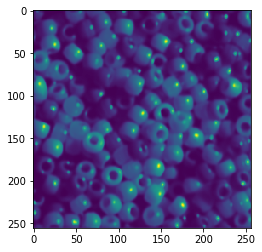

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


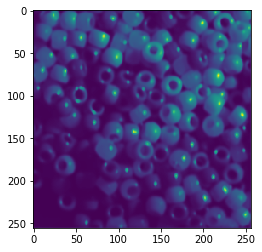

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


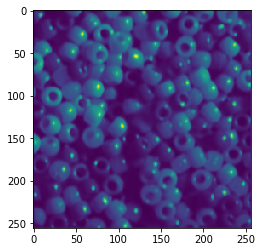

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


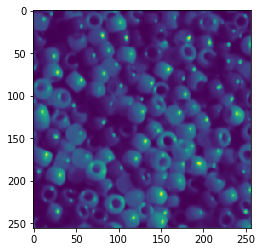

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


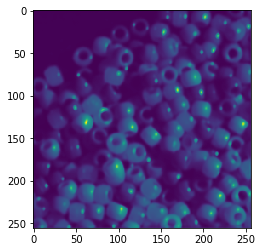

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


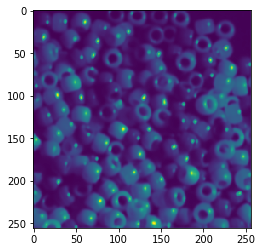

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


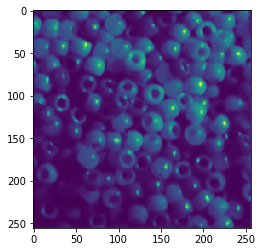

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


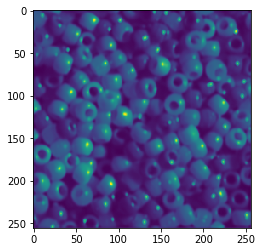

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


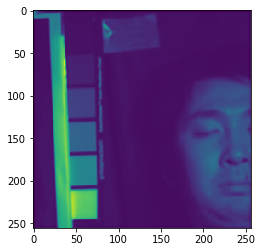

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


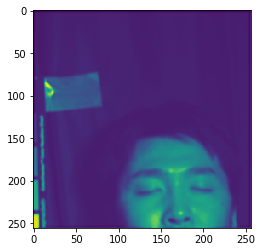

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


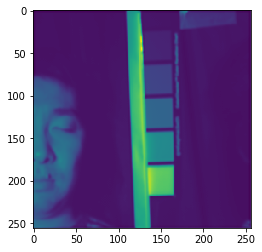

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


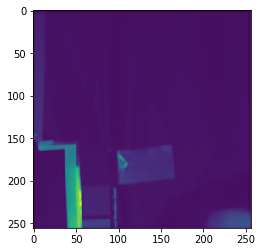

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


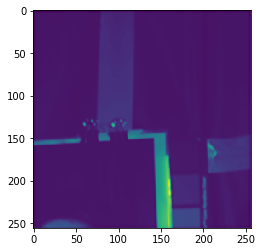

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


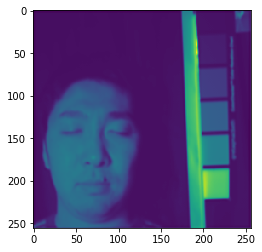

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


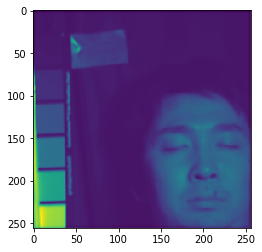

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


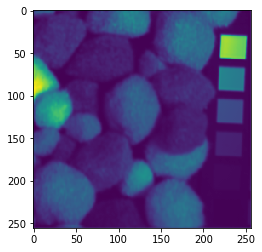

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


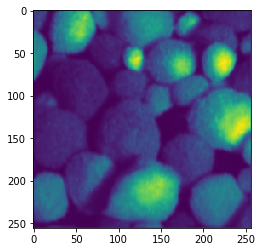

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


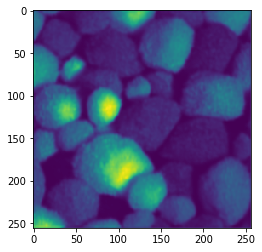

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


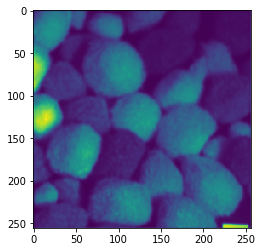

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


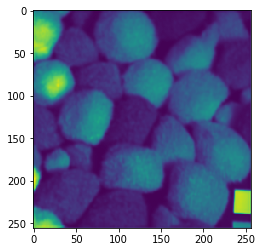

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


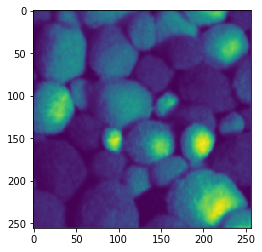

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


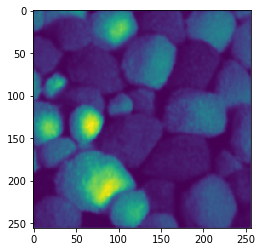

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


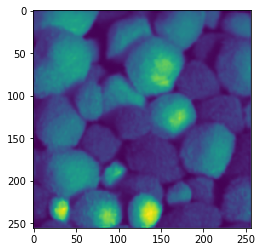

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


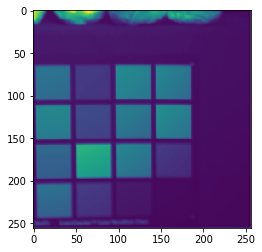

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


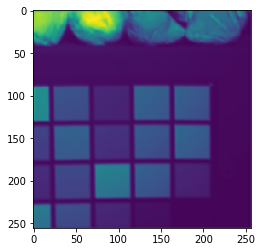

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


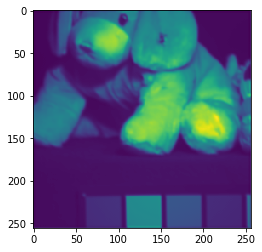

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


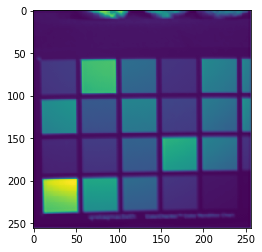

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


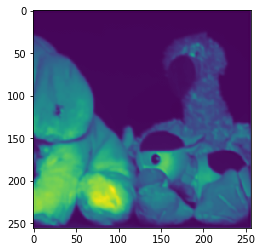

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


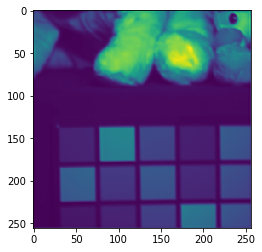

=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)


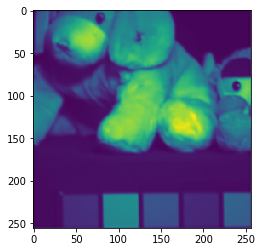

=> All validation dataset ，the average of the RMSE of  is '20.170631408691406'
=> All validation dataset ，the std of the RMSE of  is '4.353983402252197'


In [17]:
RMSE_val_all = []
for _, input_ in enumerate(val_loader):
    if cuda_available:
        input_ = input_.cuda()
    checkpointfile = "checkpoints/checkpoint_epoch_{}.pth.tar".format(0)
    if cuda.is_available():
        checkpoint = torch.load(checkpointfile)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(checkpointfile,
                                map_location=lambda storage,
                                loc: storage)
    unet.load_state_dict(checkpoint['state_dict'])
    trainlosses = checkpoint["trainlosses"]
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(checkpointfile, checkpoint['epoch']))



    output,RGB = unet(input_)
    RMSE = rmse(output,input_)
    RMSE_val_all.append(RMSE.cpu().numpy())
    #print(RMSE.size())
    plt.imshow(output[0,0, :,:].cpu().numpy())
    #plt.imshow(RMSE[0,:, :,:].squeeze(0).cpu().numpy())
    plt.show()
RMSE_val_mean = np.mean(RMSE_val_all)
RMSE_val_std = np.std(RMSE_val_all)

print("=> All validation dataset ，the average of the RMSE of  is '{}'".format(RMSE_val_mean))
print("=> All validation dataset ，the std of the RMSE of  is '{}'".format(RMSE_val_std))

In [ ]:
#####spectral response function

_, input_ = next(enumerate(val_loader))
if cuda_available:
    input_ = input_.cuda()
    checkpointfile = "checkpoints/checkpoint_epoch_{}.pth.tar".format(119)
if cuda.is_available():
    checkpoint = torch.load(checkpointfile)
else:
    # Load GPU model on CPU
    checkpoint = torch.load(checkpointfile,
                            map_location=lambda storage,
                            loc: storage)
unet.load_state_dict(checkpoint['state_dict'])
trainlosses = checkpoint["trainlosses"]
print("=> loaded checkpoint '{}' (trained for {} epochs)".format(checkpointfile, checkpoint['epoch']))



output,rgb = unet(input_)



print(unet.filter_spectral_response.weight.size())
RGB = unet.filter_spectral_response.weight


R = RGB[0,:,:,:]
print(R.size())
G = RGB[1,:,:,:]
#print(G)
B = RGB[2,:,:,:]
#print(B)


In [ ]:
plt.plot(range(400, 701, 10), R[:,0,0].cpu().numpy(), color='red', label='red')
plt.plot(range(400, 701, 10), G[:,0,0].cpu().numpy(), color='green', label='green')
plt.plot(range(400, 701, 10), B[:,0,0].cpu().numpy(), color='skyblue', label='blue')
plt.savefig('rgb.png')

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
RMSE_train_all = []
for _, input_ in enumerate(train_loader):
    if cuda_available:
        input_ = input_.cuda()
    checkpointfile = "checkpoints/checkpoint_epoch_{}.pth.tar".format(299)
    if cuda.is_available():
        checkpoint = torch.load(checkpointfile)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(checkpointfile,
                                map_location=lambda storage,
                                loc: storage)
    unet.load_state_dict(checkpoint['state_dict'])
    trainlosses = checkpoint["trainlosses"]
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(checkpointfile, checkpoint['epoch']))



    output,RGB = unet(input_)
    RMSE = rmse(output,input_)
    RMSE_train_all.append(torch.mean(RMSE).cpu().numpy())
    #print(RMSE.size())
    plt.imshow(RMSE[0,0, :,:].cpu().numpy())
    #plt.imshow(RMSE[0,:, :,:].squeeze(0).cpu().numpy())
    plt.show()
RMSE_train_mean = np.mean(RMSE_train_all)
RMSE_train_std = np.std(RMSE_train_all)
print(RMSE_train_mean)
print(RMSE_train_std)

In [ ]:
# Val loss
fig = plt.figure()
plt.semilogy(vallosses)
plt.title("Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("trainloss_epoch{}.png".format(120))

In [ ]:
# Train loss
fig = plt.figure()
plt.semilogy(trainlosses)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.savefig("trainloss_epoch{}.png".format(120))

In [ ]:
###plot 420-660 channels
# Visualize hyperspectral images
from matplotlib.colors import LinearSegmentedColormap
def plot_all_channels(data, channels_to_wavelengths,value, attributes):
    """Plot the channels in the data, color coded by wavelength.
    channels_to_wavelengths[i] gives the wavelength in nm of the ith channel."""
    plt.figure(figsize=(24, 13))
    inchannels = len(channels_to_wavelengths)
    for channel in range(inchannels):
        wavelength = channels_to_wavelengths[channel]
        #r, g, b = spectral_color(wavelength)
        
#         low = hsv_to_rgb(h, s, 0)
#         high = hsv_to_rgb(h, s, 1)
        
        #lambd = LinearSegmentedColormap('lambd', cdict)
        
        ax = plt.subplot(1, inchannels, channel+1)

        #ax.imshow(data[0,channel,:,:], cmap=lambd, origin='lower')
        #ax.set_title(attributes,fontsize=12,color='r')

        ax.imshow(data[0,channel,:,:])
        plt.axis('off')
        plt.tight_layout
        plt.savefig('/mnt/chb/hyperspectral-cs-master/plot_image/' + attributes+ str(value) + ".png")


for i, input_ in enumerate(val_loader):
    if cuda_available:
        input_ = input_.cuda()
    checkpointfile = "checkpoints/checkpoint_epoch_{}.pth.tar".format(119)
    if cuda.is_available():
        checkpoint = torch.load(checkpointfile)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(checkpointfile,
                                map_location=lambda storage,
                                loc: storage)
    unet.load_state_dict(checkpoint['state_dict'])
    trainlosses = checkpoint["trainlosses"]
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(checkpointfile, checkpoint['epoch']))



    output,RGB = unet(input_)
    RMSE = rmse(output,input_)
    
    plot_all_channels(input_.cpu(), range(420, 661, 40),i,'origin images')
    
    plot_all_channels(output.cpu(), range(420, 661, 40),i,'reconstructed images')
    
    plot_all_channels(RMSE.cpu(), range(420, 661, 40),i,'RMSE images')